In [3]:
# Import 
import os
import time
import json
import datetime
import pandas as pd
import numpy as np

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [3]:
from polarity.dynamics import EllipsoidLameGeometry as geom

In [4]:
from polarity.dynamics import RadialTension, BarrierElasticity, PerimeterElasticity
smodel = model_factory(
    [
        BarrierElasticity,
        RadialTension,
        PerimeterElasticity,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)


model = smodel

In [5]:
def init():
    dsets = hdf5.load_datasets('../examples/superegg_final.hf5',
                               data_names=['vert', 'edge', 'face'])

    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)

    sheet = Sheet('spherical', dsets, specs)    
    
    sheet.settings['geometry'] = "spherical"
    sheet.settings['barrier_ray'] = 100

    sheet.vert_df['barrier_elasticity'] = 280.0
    sheet.vert_df['delta_rho'] = 0
    
    # A définir en fonction de l'angle de la jonction
    sheet.edge_df['weighted'] = 1.
    sheet.edge_df['weighted_length'] = sheet.edge_df.weighted * sheet.edge_df.length
    
    sheet.face_df['radial_tension'] = 0.0
    sheet.face_df['prefered_perimeter'] = 2*np.sqrt(sheet.face_df['prefered_area'])
    sheet.face_df['perimeter_elasticity'] = 5.
    sheet.face_df['area_elasticity'] = 1.
    
    sheet.settings['lumen_prefered_vol'] = 1655117.87836963126
    
    return sheet
sheet=init()

In [6]:
solver = QSSolver(with_t1=False, with_t3=False)

In [7]:
sheet.settings['lumen_prefered_vol']

1655117.8783696312

## Test several value of yolk volume elasticity

In [8]:

"""volume = [1.e-11, 1.e-10, 1.e-9, 5.e-9, 1.e-8, 2.e-8, 3.e-8,  4.e-8, 7.e-8, 8.e-8,
          1.e-7,2.e-7, 3.e-7, 4.e-7, 7.e-7,8.e-7,9.e-7, 1.e-6, 3.e-6, 4.e-6, 7.e-6, 8.e-6,
          1.e-5,2.e-5, 3.e-5, 5.e-5, 7.e-5, 1.e-4, 1.e-3, 1.e-2, 1.e-1]
"""
volume = [1.e-11, 1.e-10, 1.e-9, 1.e-8, 1.e-7, 1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2, 1.e-1]
volume_dataframe = pd.DataFrame(columns=['compression'])
for v in volume : 
    sheet=init()
    print (v)
    sheet.settings['lumen_vol_elasticity'] = v
    
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
    
    tp = (v, sheet.settings['lumen_vol']/sheet.settings['lumen_prefered_vol'])
    volume_dataframe.loc[v, 'elasticity'] = tp[1]

volume_dataframe["compression"] = 100-volume_dataframe["elasticity"]*100
volume_dataframe.to_csv('resultats_yolk.csv')


1e-11
1e-10
1e-09
1e-08
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1


/home/admin-suz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


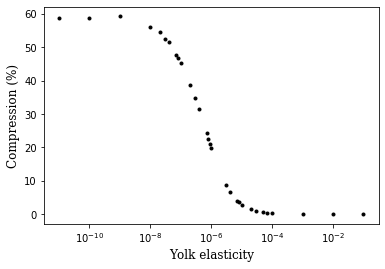

In [4]:
volume_dataframe = pd.DataFrame.from_csv('resultats_yolk.csv')
fig = plt.figure()
ax = fig.add_subplot(111)
volume_dataframe = volume_dataframe.drop(volume_dataframe[volume_dataframe.elasticity == 0].index)
ax.plot(volume_dataframe.index, (1-volume_dataframe.elasticity)*100, '.', color = 'black')

#ax.plot(3.e-6, (1-volume_dataframe.loc[3.e-6, 'elasticity'])*100, 'o',color = 'red')
#ax.axvline(x=3.e-6,ymin=0, ymax=0.08, linewidth=1,linestyle='--', color='red')
#ax.axhline(y=(1-volume_dataframe.loc[3.e-6, 'elasticity'])*100, xmin=0, xmax=0.55,
#           linewidth=1,linestyle='--', color='red')


ax.set_xscale("log")
ax.set_xlabel('Yolk elasticity', size=12, family='serif')
ax.set_ylabel('Compression (%)', size=12, family='serif')
#ax.vlines(3e-6, 0, 50)

plt.savefig('yolkElasticity.eps', dpi = 300, transparent=True)
plt.savefig("yolkElasticity.pdf", dpi = 300, transparent=True)


In [10]:
# add some values

volume = [ 2.e-8, 3.e-8,  4.e-8, 7.e-8, 8.e-8, 2.e-7, 3.e-7, 4.e-7, 
          7.e-7,8.e-7,9.e-7, 3.e-6, 4.e-6, 7.e-6, 8.e-6,
          2.e-5, 3.e-5, 5.e-5, 7.e-5]

for v in volume : 
    sheet=init()
    print (v)
    sheet.settings['lumen_vol_elasticity'] = v
    
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
    
    tp = (v, sheet.settings['lumen_vol']/sheet.settings['lumen_prefered_vol'])
    volume_dataframe.loc[v, 'elasticity'] = tp[1]

volume_dataframe["compression"] = 100-volume_dataframe["elasticity"]*100
volume_dataframe.to_csv('resultats_yolk.csv')


2e-08
3e-08
4e-08
7e-08
8e-08
2e-07
3e-07
4e-07
7e-07
8e-07
9e-07
3e-06
4e-06
7e-06
8e-06
2e-05
3e-05
5e-05
7e-05


/home/admin-suz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


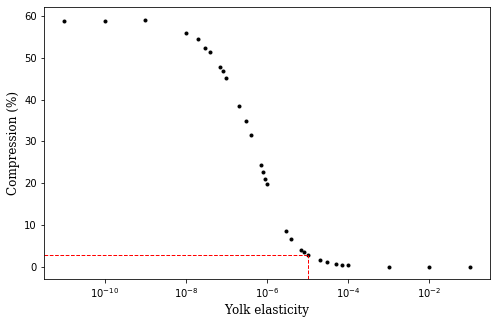

In [26]:
volume_dataframe = pd.DataFrame.from_csv('resultats_yolk.csv')
fig = plt.figure(1,figsize=(8, 5))
ax = fig.add_subplot(111)
volume_dataframe = volume_dataframe.drop(volume_dataframe[volume_dataframe.elasticity == 0].index)
ax.plot(volume_dataframe.index, (1-volume_dataframe.elasticity)*100, '.', color = 'black')

#ax.plot(3.e-6, (1-volume_dataframe.loc[3.e-6, 'elasticity'])*100, 'o',color = 'red')
ax.axvline(x=1.e-5,ymin=0, ymax=0.09, linewidth=1,linestyle='--', color='red')
ax.axhline(y=(1-volume_dataframe.loc[1.e-5, 'elasticity'])*100, xmin=0, xmax=0.59,
           linewidth=1,linestyle='--', color='red')


ax.set_xscale("log")
ax.set_xlabel('Yolk elasticity', size=12, family='serif')
ax.set_ylabel('Compression (%)', size=12, family='serif')


plt.savefig('yolkElasticity.svg', dpi = 300, transparent=True)
plt.savefig("yolkElasticity.pdf", dpi = 300, transparent=True)
